In [1]:
import pickle as pkl
import argparse
import os
import pickle
import random
import numpy as np
import torch
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score

from pcbm.data import get_dataset
from pcbm.concepts import ConceptBank
from pcbm.models import PosthocLinearCBM, get_model
from pcbm.training_tools import load_or_compute_projections

UNIVERSAL_SEED = 2024
BATCH_SIZE = 64
NUM_WORKERS = 4
CONCEPT_BANK_PATH = "/home/ksas/Public/datasets/cifar10_concept_bank/multimodal_concept_clip:RN50_cifar10_recurse:1.pkl"
OUT_PUT_DIR_PATH = "exps/test"
CKPT_PATH = "data/ckpt/pcbm_cifar10__clip:RN50__multimodal_concept_clip:RN50_cifar10_recurse:1__lam:0.0002__alpha:0.99__seed:42.ckpt"
DATASET_PATH = "/home/ksas/Public/datasets/cifar10_concept_bank"
BACKBONE_NAME = "clip:RN50"
DEVICE = "cuda"

In [2]:
def set_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
set_random_seed(UNIVERSAL_SEED)

In [3]:
all_concepts = pkl.load(open(CONCEPT_BANK_PATH, 'rb'))
all_concept_names = list(all_concepts.keys())
print(f"Bank path: {CONCEPT_BANK_PATH}. {len(all_concept_names)} concepts will be used.")
concept_bank = ConceptBank(all_concepts, DEVICE)


import clip
clip_backbone_name = BACKBONE_NAME.split(":")[1]
backbone, preprocess = clip.load(clip_backbone_name, device=DEVICE, download_root="/home/ksas/Public/model_zoo/clip")
backbone = backbone.eval()
backbone = backbone.float()
model = None

backbone = backbone.to(DEVICE)
backbone.eval()

Bank path: /home/ksas/Public/datasets/cifar10_concept_bank/multimodal_concept_clip:RN50_cifar10_recurse:1.pkl. 175 concepts will be used.
Concept Bank is initialized.


CLIP(
  (visual): ModifiedResNet(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
     

In [4]:
posthoc_layer:PosthocLinearCBM = torch.load(CKPT_PATH, map_location=DEVICE)
print(posthoc_layer.analyze_classifier(k=5))
print(posthoc_layer.names)
print(posthoc_layer.names.__len__())

Class : airplane
	 1 - propellers: 23.521
	 2 - heavier-than-air craft: 20.789
	 3 - fuselage: 19.204
	 4 - accelerator: 12.065
	 5 - landing gear: 10.263
Class : automobile
	 1 - motor vehicle: 16.571
	 2 - gear shift: 12.492
	 3 - windshield wiper: 12.015
	 4 - vehicle type: 11.890
	 5 - windshield: 11.806
Class : bird
	 1 - beak: 20.205
	 2 - bird's foot: 17.873
	 3 - crow's nest: 9.056
	 4 - legs: 8.955
	 5 - drumstick: 8.385
Class : cat
	 1 - feline: 27.793
	 2 - gray: 8.813
	 3 - sharp claws: 7.922
	 4 - galley: 7.879
	 5 - radiator: 7.709
Class : deer
	 1 - antler: 22.699
	 2 - an antler: 18.923
	 3 - propellers: 16.775
	 4 - lubber's hole: 8.735
	 5 - ruminant: 6.916
Class : dog
	 1 - canine: 19.039
	 2 - white: 13.807
	 3 - wishbone: 8.590
	 4 - paws: 6.753
	 5 - mute: 5.895
Class : frog
	 1 - amphibian: 26.766
	 2 - bulkhead: 18.490
	 3 - uropygium: 18.017
	 4 - ridge rope: 14.598
	 5 - uropygial gland: 10.396
Class : horse
	 1 - horseback: 22.419
	 2 - equine: 15.334
	 3 - h

In [5]:
from torchvision import datasets
from pcbm.learn_concepts_multimodal import *
trainset = datasets.CIFAR10(root=DATASET_PATH, train=True,
                            download=True, transform=preprocess)
testset = datasets.CIFAR10(root=DATASET_PATH, train=False,
                            download=True, transform=preprocess)
classes = trainset.classes
class_to_idx = {c: i for (i,c) in enumerate(classes)}
idx_to_class = {v: k for k, v in class_to_idx.items()}
train_loader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                        shuffle=True, num_workers=NUM_WORKERS)
test_loader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                    shuffle=False, num_workers=NUM_WORKERS)

Files already downloaded and verified
Files already downloaded and verified


2
x: torch.Size([64, 3, 224, 224])
y: torch.Size([64])


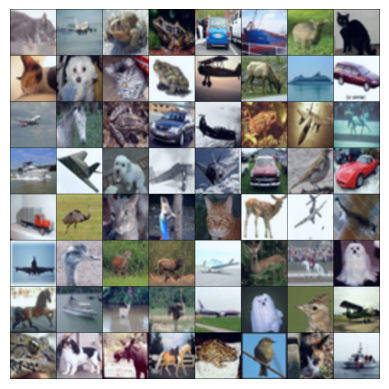

embeddings: torch.Size([64, 1024])
projections: torch.Size([64, 175])
predicted_Y: torch.Size([64, 10])
accuracy: 0.859375
> /tmp/ipykernel_3237628/1754518265.py(14)<module>()
     12     plt.show()
     13 
---> 14 for idx, data in enumerate(train_loader):
     15     print(data.__len__())
     16     print(f"x: {data[0].size()}")

torch.Size([64, 3, 224, 224])
tensor(-1.7923, device='cuda:0', grad_fn=<MinBackward1>)


In [6]:
def show_image(images:torch.Tensor):
    import torch
    import torchvision
    import matplotlib.pyplot as plt

    # 使用 torchvision.utils.make_grid 将 64 张图片排列成 8x8 的网格
    grid_img = torchvision.utils.make_grid(images, nrow=8, normalize=True)

    # 转换为 NumPy 格式以便用 matplotlib 显示
    plt.imshow(grid_img.permute(1, 2, 0))  # 转换为 [H, W, C]
    plt.axis('off')  # 隐藏坐标轴
    plt.show()

for idx, data in enumerate(train_loader):
    print(data.__len__())
    print(f"x: {data[0].size()}")
    print(f"y: {data[1].size()}")
    batch_X, batch_Y = data
    batch_X = batch_X.to(DEVICE)
    batch_Y = batch_Y.to(DEVICE)
    
    batch_X.requires_grad_(True)
    embeddings = backbone.encode_image(batch_X)
    projs = posthoc_layer.compute_dist(embeddings)
    predicted_Y = posthoc_layer.forward_projs(projs)
    accuracy = (predicted_Y.argmax(1) == batch_Y).float().mean().item()
    
    _, topk_indices = torch.topk(projs, 5, dim=1)
    topk_concept = [[posthoc_layer.names[idx] for idx in row] for row in topk_indices]

    
    show_image(batch_X.detach().cpu())
    print(f"embeddings: {embeddings.size()}")
    print(f"projections: {projs.size()}")
    print(f"predicted_Y: {predicted_Y.size()}")
    print(f"accuracy: {accuracy}")
    # accuracy_idx.append(accuracy)
    import pdb; pdb.set_trace()
    
# print(accuracy_idx)
    